In [2]:
import torch

# Kiểm tra nếu GPU khả dụng, nếu không thì dùng CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

class UpscaleBlock(nn.Module):
    def __init__(self):
        super(UpscaleBlock, self).__init__()
        self.conv = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.prelu = nn.PReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.prelu(out)
        return out    
    
class Generator(nn.Module):
    def __init__(self, num_res_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.prelu = nn.PReLU()
        self.res_blocks = nn.Sequential(*[ResBlock() for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.upscale1 = UpscaleBlock()
        self.upscale2 = UpscaleBlock()
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        out1 = self.conv1(x)
        out1 = self.prelu(out1)
        out = self.res_blocks(out1)
        out = self.conv2(out)
        out = self.bn(out)
        out += out1
        out = self.upscale1(out)
        out = self.upscale2(out)
        out = self.conv3(out)
        return out
    
generator = Generator().to(device)    

In [9]:
from torchvision import models

class VGGFeatureExtractor(nn.Module):
    def __init__(self, vgg_weights_path):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = models.vgg19()
        if vgg_weights_path:
            state_dict = torch.load(vgg_weights_path)
            vgg19.load_state_dict(state_dict, strict=False)  # Handle potential key mismatches


        self.features = nn.Sequential(*list(vgg19.features.children())[:11]) #Up to 10th layer for content loss
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        return self.features(x)
    
vgg_weights_path = '/kaggle/input/vgg19-weights-pth/vgg19-dcbb9e9d.pth' # Replace with your path
vgg = VGGFeatureExtractor(vgg_weights_path).to(device)    

criterion_gan = nn.BCEWithLogitsLoss()  # Includes Sigmoid
criterion_content = nn.MSELoss()

/tmp/ipykernel_30/4072374424.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(vgg_weights_path)


/tmp/ipykernel_30/3625529377.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/kaggle/input/output-srgan/final_generator.pt"))


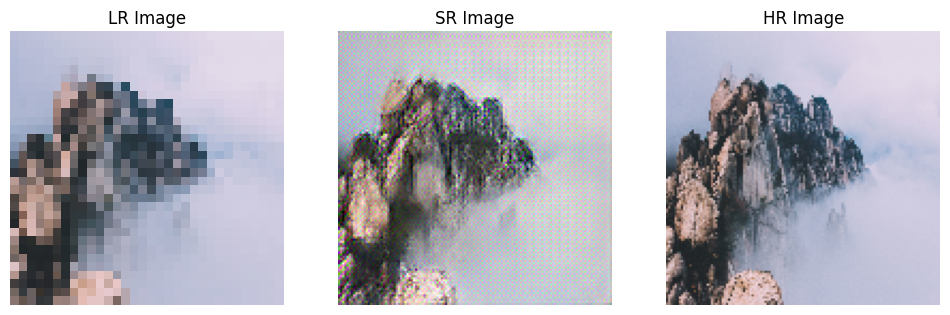

Content Loss for SR Image: 1.9761719703674316


In [18]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms


# Đường dẫn đến các thư mục chứa ảnh HR và LR
hr_path = "/kaggle/input/output-srgan/hr_images/"
lr_path = "/kaggle/input/output-srgan/lr_images/"

# Hàm để tải và chuyển đổi ảnh thành tensor
def load_image(filepath):
    img = Image.open(filepath).convert("RGB")
    transform = transforms.ToTensor()
    return transform(img)

# Tải danh sách ảnh trong thư mục
hr_images = [os.path.join(hr_path, f) for f in os.listdir(hr_path)]
lr_images = [os.path.join(lr_path, f) for f in os.listdir(lr_path)]

# Chọn một ảnh ngẫu nhiên từ LR và HR
ix = np.random.randint(0, len(lr_images))
lr_image = load_image(lr_images[ix]).unsqueeze(0).to(device)
hr_image = load_image(hr_images[ix]).unsqueeze(0).to(device)

# Tải mô hình generator
generator.load_state_dict(torch.load("/kaggle/input/output-srgan/final_generator.pt"))
generator.eval()

# Generate SR image
with torch.no_grad():
    sr_image = generator(lr_image)

# Calculate loss for the SR image
vgg_features_real = vgg(hr_image)
vgg_features_fake = vgg(sr_image)
content_loss = criterion_content(vgg_features_fake, vgg_features_real).item()  # Get the scalar value



# Move images back to CPU and convert to NumPy for display
lr_image = lr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
hr_image = hr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
sr_image = sr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()


# Display images and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("LR Image")
plt.imshow(lr_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("SR Image")
plt.imshow(sr_image)
plt.axis("off")


plt.subplot(1, 3, 3)
plt.title("HR Image")
plt.imshow(hr_image)
plt.axis("off")

plt.show()



print(f"Content Loss for SR Image: {content_loss}")